#Worksheet-6

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Necessary Tools

In [39]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

##Task-1

In [40]:
train_dir = "/content/drive/MyDrive/AI  and  Machine Learning /Week5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI  and  Machine Learning /Week5/FruitinAmazon/test"

In [41]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['graviola', 'guarana', 'cupuacu', 'acai', 'pupunha', 'tucuma']


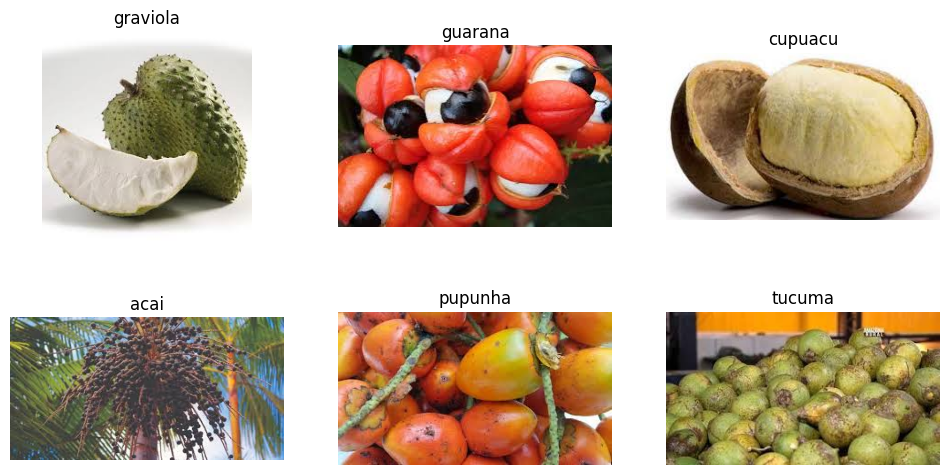

In [42]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [17]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [18]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

In [20]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=123
)

Found 24 images belonging to 6 classes.


In [21]:
val_ds = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=123
)

Found 6 images belonging to 6 classes.


In [22]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651,398 (128.37 MB)

 Trainable params: 33,650,438 (128.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0417 - loss: 3.9456

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0417 - loss: 3.9456 - val_accuracy: 0.1667 - val_loss: 5.1598 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6667 - loss: 2.3688 - val_accuracy: 0.1667 - val_loss: 4.7939 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 1.9228 - val_accuracy: 0.1667 - val_loss: 4.2463 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 1.7216 - val_accuracy: 0.1667 - val_loss: 3.8578 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 1.8952 - val_accuracy: 0.1667 - val_loss: 3.6708 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8750 - loss: 1.6628 - val_accuracy: 0.1667 - val_loss: 3.3032 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 1.7582 - val_accuracy: 0.1667 - val_loss: 2.9916 - le

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9167 - loss: 1.6733 - val_accuracy: 0.3333 - val_loss: 2.9616 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8333 - loss: 1.6910 - val_accuracy: 0.3333 - val_loss: 3.5289 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8750 - loss: 1.5117 - val_accuracy: 0.3333 - val_loss: 4.3730 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8333 - loss: 1.7222 - val_accuracy: 0.1667 - val_loss: 5.1428 - learning_rate: 5.0000e-04
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7917 - loss: 1.8491 - val_accuracy: 0.0000e+00 - val_loss: 6.0830 - learning_rate: 5.0000e-04


In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - accuracy: 0.2000 - loss: 2.8274
Test Accuracy: 20.00%


In [26]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [27]:
y_true = test_ds.classes
y_pred = np.argmax(loaded_model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
              precision    recall  f1-score   support

     cupuacu       0.00      0.00      0.00         5
      tucuma       0.33      0.20      0.25         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.28      1.00      0.43         5
        acai       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.10      0.20      0.11        30
weighted avg       0.10      0.20      0.11        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


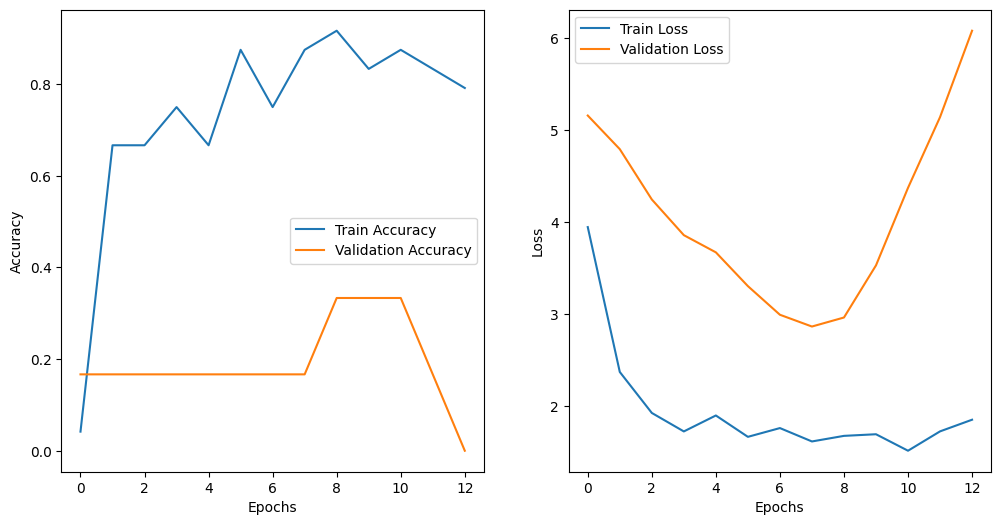

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##Task-2

In [29]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
callbacks = [
    ModelCheckpoint("best_model_tl.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model (only top layers)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1250 - loss: 2.5924

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1250 - loss: 2.5924 - val_accuracy: 0.1667 - val_loss: 1.9561 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4167 - loss: 1.6656

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step - accuracy: 0.4167 - loss: 1.6656 - val_accuracy: 0.3333 - val_loss: 1.6924 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.4167 - loss: 1.6450 - val_accuracy: 0.3333 - val_loss: 1.5815 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4167 - loss: 1.6945 - val_accuracy: 0.3333 - val_loss: 1.3780 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6667 - loss: 0.9223

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - accuracy: 0.6667 - loss: 0.9223 - val_accuracy: 0.6667 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.7083 - loss: 0.8163 - val_accuracy: 0.6667 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9583 - loss: 0.3236

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 0.9583 - loss: 0.3236 - val_accuracy: 0.8333 - val_loss: 0.7800 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8750 - loss: 0.5019 - val_accuracy: 0.8333 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 0.8333 - loss: 0.3751 - val_accuracy: 0.8333 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - accuracy: 0.9583 - loss: 0.3535 - val_accuracy: 0.8333 - val_loss: 0.5022 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.9583 - loss: 0.1902 - val_accuracy: 0.8333 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.9167 - loss: 0.2774 - val_accuracy: 0.8333 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 1.0000 - loss: 0.1316 - val_accuracy: 0.8333 

In [33]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9667 - loss: 0.1021
Test Accuracy: 96.67%


In [34]:
model.save("final_model_tl.h5")

loaded_model = tf.keras.models.load_model("final_model_tl.h5")

In [35]:
y_true = test_ds.classes
y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Inference Output: First 20 Samples:")
for i in range(20):
    true_label = class_names[int(y_true[i])]
    pred_label = class_names[int(y_pred[i])]
    print(f"{i+1}. True: {true_label} - Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Inference Output: First 20 Samples:
1. True: cupuacu - Predicted: cupuacu
2. True: cupuacu - Predicted: cupuacu
3. True: cupuacu - Predicted: cupuacu
4. True: cupuacu - Predicted: cupuacu
5. True: cupuacu - Predicted: cupuacu
6. True: tucuma - Predicted: tucuma
7. True: tucuma - Predicted: tucuma
8. True: tucuma - Predicted: tucuma
9. True: tucuma - Predicted: tucuma
10. True: tucuma - Predicted: tucuma
11. True: graviola - Predicted: graviola
12. True: graviola - Predicted: graviola
13. True: graviola - Predicted: graviola
14. True: graviola - Predicted: graviola
15. True: graviola - Predicted: graviola
16. True: guarana - Predicted: guarana
17. True: guarana - Predicted: guarana
18. True: guarana - Predicted: guarana
19. True: guarana - Predicted: guarana
20. True: guarana - Predicted: guarana


In [36]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     cupuacu       1.00      1.00      1.00         5
      tucuma       0.83      1.00      0.91         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      1.00      1.00         5
     pupunha       1.00      1.00      1.00         5
        acai       1.00      0.80      0.89         5

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



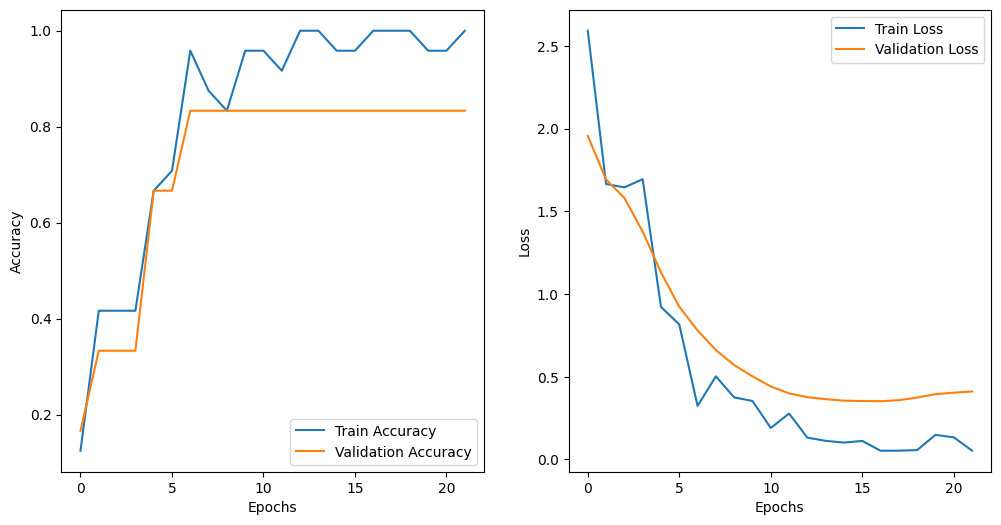

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()